In [1]:
# Install packages
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn scikit-learn shap

In [2]:
# Functions to pull data
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd

def get_url(dataset, year):
    base_url = "https://www.fhfa.gov/DataTools/Downloads/Documents/Enterprise-PUDB/"

    dataset_map = {
        "Multifamily-Census": f"Multi-Family_Census_Tract_File_/{year}_MFCensusTract{year}.zip",
        "Multifamily-National": f"Multi-Family_National_File_/{year}_MFNationalFile{year}.zip",
        "Singlefamily-Census-Fannie": f"Single-Family_Census_Tract_File_/{year}_SFCensusTractFNM{year}.zip",
        "Singlefamily-Census-Freddie": f"Single-Family_Census_Tract_File_/{year}_SFCensusTractFRE{year}.zip",
        "Singlefamily-National-A-Fannie": f"National-File-A/{year}_SFNationalFileA{year}.zip",
        "Singlefamily-National-A-Freddie": f"National-File-A/{year}_SFNationalFileA{year}.zip",
        "Singlefamily-National-B-Fannie": f"National-File-B/{year}_SFNationalFileB{year}.zip",
        "Singlefamily-National-B-Freddie": f"National-File-B/{year}_SFNationalFileB{year}.zip",
        "Singlefamily-National-C-Fannie": f"National-File-C/{year}_SFNationalFileC{year}.zip",
        "Singlefamily-National-C-Freddie": f"National-File-C/{year}_SFNationalFileC{year}.zip"
    }

    return base_url + dataset_map.get(dataset)


def get_data(dataset, year):
    # the name of the file within the downloaded zip file
    file_map = {
        "Singlefamily-Census-Freddie": f"fhlmc_sf{year}c_loans.txt",
        "Singlefamily-Census-Fannie": f"fnma_sf{year}c_loans.txt",
        "Singlefamily-National-A-Fannie": f"fnma_sf{year}a_loans.txt",
        "Singlefamily-National-A-Freddie": f"fhlmc_sf{year}a_loans.txt"
        # TODO
    }
    filename = file_map.get(dataset)

    # TODO: we can define how we parse each type of file differently
    # for now, we assume we are only parsing a single file at a time
    parser_map = {
        "Singlefamily-Census-Freddie": parse_singlefamily_census,
        "Singlefamily-Census-Fannie": parse_singlefamily_census,
        "Singlefamily-National-A-Fannie": parse_national_a,
        "Singlefamily-National-A-Freddie": parse_national_a
    }
    parser = parser_map.get(dataset, parse_default)

    url = get_url(dataset, year)
    resp = urlopen(url)
    zipreader = ZipFile(BytesIO(resp.read()))
    
    return parser(zipreader.open(filename))

def parse_default(fileobj):
    return pd.read_csv(fileobj)

def parse_singlefamily_census(fileobj):
    # documentation: https://www.fhfa.gov/DataTools/Downloads/Documents/Enterprise-PUDB/Single-Family_Census_Tract_File_/2022_Single_Family_Census_Tract_File.pdf
    # note: check documentation for the specific year you are pulling data from. Not all columns are present for all years
    colnames = ["enterprise_flag",
                "record_num",
                "state_fips_code",
                "msa_code",
                "county_fips_code",
                "census_tract", # pre-2012: 2000 census data; 2012-2021: 2010 census data; 2022: 2020 census data
                "tract_pct_minority",
                "tract_median_income",
                "local_median_income",
                "tract_income_ratio",
                "borrower_income",
                "local_median_family_income",
                "borrower_income_ratio",
                "upb",
                "purpose",
                "federal_guarantee",
                "num_borrowers",
                "first_time_buyer",
                "borrower_race_1", # 5 columns for borrower race; first 4 seem mostly N/A
                "borrower_race_2", # TODO: is there a better way to parse these 5 cols?
                "borrower_race_3",
                "borrower_race_4",
                "borrower_race", # use this
                "borrower_ethnicity",
                "co-borrower_race_1", # 5 columns for co-borrower race; see above
                "co-borrower_race_2",
                "co-borrower_race_3",
                "co-borrower_race_4",
                "co-borrower_race",
                "co-borrower_ethnicity",
                "borrower_gender",
                "co-borrower_gender",
                "borrower_age",
                "co-borrower_age",
                "occupancy_code",
                "rate_spread",
                "HOEPA_status",
                "property_type",
                "lien_status",
                "borrower_62+",
                "co-borrower_62+",
                "ltv",
                "date_of_note",
                "term_at_orig",
                "num_units",
                "rate_at_orig",
                "note_amount",
                "preapproval",
                "application_channel",
                "AUS_name",
                "borrower_credit_model",
                "co-borrower_credit_model",
                "dti",
                "discount_points",
                "intro_rate_period",
                "land_property_interest",
                "property_value",
                "rural_tract",
                "mississippi_delta_county",
                "mid_appalachia_county",
                "persistent_poverty_county",
                "area_concentrated_poverty",
                "high_opportunity_area",
                "qualified_opportunity_zone_tract"]
    return pd.read_csv(fileobj, names=colnames, delimiter='\s+') # TODO: clean
                
        

def parse_national_a(fileobj):
    # documentation: https://fhfa.gov/DataTools/Downloads/Documents/Enterprise-PUDB/National-File-A/2022_Single_Family_National_File_A.pdf
    colnames = ["enterprise_flag",
                "record_num",
                "msa_code",
                "tract_pct_minority", # pre-2012: 2000 census data; 2012-2021: 2010 census data; 2022: 2020 census data
                "tract_income_ratio",
                "borrower_income_ratio",
                "ltv",
                "purpose",
                "federal_guarantee",
                "borrower_race",
                "co-borrower_race",
                "borrower_gender",
                "co-borrower_gender",
                "num_units",
                "affordability"]
    return pd.read_csv(fileobj, names=colnames, delimiter='\s+')

In [3]:
# Pull Freddie Mac 2022 Single Family Census Tract data
singlefamily_census_freddie_latest = get_data("Singlefamily-Census-Freddie", 2022)

In [4]:
# Clean data
def map_dti_to_label(dti):
    if dti == 10:
        return '< 20%'
    elif dti == 20:
        return '20-29%'
    elif dti == 30:
        return '30-35%'
    elif 36 <= dti <= 40:
        return '36-40%'
    elif 41 <= dti <= 45:
        return '41-45%'
    elif 46 <= dti <= 98:
        return '> 46%'

import numpy as np
#from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get general understanding of the data
print("\n Shape of the data 'singlefamily_census_freddie_latest' ->")  # (1800763, 64)
print("---------------------------------------------")
display(singlefamily_census_freddie_latest.shape)
print("\n Data information ->")
print("---------------------------------------------")
display(singlefamily_census_freddie_latest.info())
print("\n Describing the data ->")
print("---------------------------------------------")
display(singlefamily_census_freddie_latest.describe())
print("\n Check for nulls in each column ->")
print("---------------------------------------------")
singlefamily_census_freddie_latest = singlefamily_census_freddie_latest.replace('', np.nan)
display(singlefamily_census_freddie_latest.isnull().sum())
print("\n Unique values in each column ->")
print("---------------------------------------------")
display(singlefamily_census_freddie_latest.nunique())

print("\n Preprocessing the data: clean")
print("---------------------------------------------")
print("Excludes Field#: 1, 2, 64(all nulls)")
n = 1800763 # total number of records in the dataset
df_sf_fred_2022 = singlefamily_census_freddie_latest.iloc[:, 2:63]
print("Shape of data 'df_sf_fred_2022' after removing 3 columns ->", df_sf_fred_2022.shape)  #(1800763, 61)
# display(df_sf_fred_2022.head(1))

print("Check missing, NA values for each column (shown in percent of total data)")
print("---------------------------------------------")
print("Missing vals (00) in 'state_fips_code' ->", round(((df_sf_fred_2022["state_fips_code"] == 0).sum())*100/n, 5))
print("Missing vals (00000) in 'msa_code' ->", round(((df_sf_fred_2022["msa_code"] == 0).sum())*100/n, 5))
print("Missing vals (00000) in 'county_fips_code' ->", round(((df_sf_fred_2022["county_fips_code"] == 0).sum())*100/n, 5))
print("Missing vals (000000) in 'census_tract' ->", round(((df_sf_fred_2022["census_tract"] == 0).sum())*100/n, 5))
print("NA vals (9999.0) in 'tract_pct_minority' ->", round(((df_sf_fred_2022["tract_pct_minority"] == 9999.0).sum())*100/n, 5))
print("NA vals (999999) in 'tract_median_income' ->", round(((df_sf_fred_2022["tract_median_income"] == 999999).sum())*100/n, 5))
print("NA vals (999999) in 'local_median_income' ->", round(((df_sf_fred_2022["local_median_income"] == 999999).sum())*100/n, 5))
print("NA vals (9999.000) in 'tract_income_ratio' ->", round(((df_sf_fred_2022["tract_income_ratio"] == 9999.000).sum())*100/n, 5))
print("NA vals (999999999) in 'borrower_income' ->", round(((df_sf_fred_2022["borrower_income"] == 999999999).sum())*100/n, 5))
print("NA vals (999999) in 'local_median_family_income' ->", round(((df_sf_fred_2022["local_median_family_income"] == 999999).sum())*100/n, 5))
print("NA vals (9999.000) in 'borrower_income_ratio' ->", round(((df_sf_fred_2022["borrower_income_ratio"] == 9999.000).sum())*100/n, 5))
print("NA vals (999999999) in 'upb' ->", round(((df_sf_fred_2022["upb"] == 999999999).sum())*100/n, 5))
print("NA vals (9) in 'purpose' ->", round(((df_sf_fred_2022["purpose"] == 9).sum())*100/n, 5))
print("Missing vals (99) in 'num_borrowers' ->", round(((df_sf_fred_2022["num_borrowers"] == 99).sum())*100/n, 5))
print("NA vals (9) in 'first_time_buyer' ->", round(((df_sf_fred_2022["first_time_buyer"] == 9).sum())*100/n, 5))
print("NA vals (6,7,9) in 'borrower_race_1' ->", round(((df_sf_fred_2022["borrower_race_1"].isin([6, 7, 9])).sum())*100/n, 5))
print("NA vals (6,7,9) in 'borrower_race_2' ->", round(((df_sf_fred_2022["borrower_race_2"].isin([6, 7, 9])).sum())*100/n, 5))
print("NA vals (6,7,9) in 'borrower_race_3' ->", round(((df_sf_fred_2022["borrower_race_3"].isin([6, 7, 9])).sum())*100/n, 5))
print("NA vals (6,7,9) in 'borrower_race_4' ->", round(((df_sf_fred_2022["borrower_race_4"].isin([6, 7, 9])).sum())*100/n, 5))
print("NA vals (6,7,9) in 'borrower_race' ->", round(((df_sf_fred_2022["borrower_race"].isin([6, 7, 9])).sum())*100/n, 5))
print("NA vals (3,4,9) in 'borrower_ethnicity' ->", round(((df_sf_fred_2022["borrower_ethnicity"].isin([3, 4, 9])).sum())*100/n, 5))
print("NA vals (6,7,8,9) in 'co-borrower_race_1' ->", round(((df_sf_fred_2022["co-borrower_race_1"].isin([6, 7, 8, 9])).sum())*100/n, 5))
print("NA vals (6,7,8,9) in 'co-borrower_race_2' ->", round(((df_sf_fred_2022["co-borrower_race_2"].isin([6, 7, 8, 9])).sum())*100/n, 5))
print("NA vals (6,7,8,9) in 'co-borrower_race_3' ->", round(((df_sf_fred_2022["co-borrower_race_3"].isin([6, 7, 8, 9])).sum())*100/n, 5))
print("NA vals (6,7,8,9) in 'co-borrower_race_4' ->", round(((df_sf_fred_2022["co-borrower_race_4"].isin([6, 7, 8, 9])).sum())*100/n, 5))
print("NA vals (6,7,8,9) in 'co-borrower_race' ->", round(((df_sf_fred_2022["co-borrower_race"].isin([6, 7, 8, 9])).sum())*100/n, 5))
print("NA vals (3,4,5,9) in 'co-borrower_ethnicity' ->", round(((df_sf_fred_2022["co-borrower_ethnicity"].isin([3, 4, 5, 9])).sum())*100/n, 5))
print("NA vals (3,4,9) in 'borrower_gender' ->", round(((df_sf_fred_2022["borrower_gender"].isin([3, 4, 9])).sum())*100/n, 5))
print("NA vals (3,4,5,9) in 'co-borrower_gender' ->", round(((df_sf_fred_2022["co-borrower_gender"].isin([3, 4, 5, 9])).sum())*100/n, 5))
print("NA vals (9) in 'borrower_age' ->", round(((df_sf_fred_2022["borrower_age"] == 9).sum())*100/n, 5))
print("NA vals (9) in 'co-borrower_age' ->", round(((df_sf_fred_2022["co-borrower_age"] == 9).sum())*100/n, 5))
print("NA vals (9) in 'occupancy_code' ->", round(((df_sf_fred_2022["occupancy_code"] == 9).sum())*100/n, 5))
print("NA vals (0) in 'rate_spread' (% of tot records) ->", round(((df_sf_fred_2022["rate_spread"] == 0).sum())*100/n, 5))
print("NA vals (9) in 'HOEPA_status' ->", round(((df_sf_fred_2022["HOEPA_status"] == 9).sum())*100/n, 5))
print("NA vals (9) in 'property_type' ->", round(((df_sf_fred_2022["property_type"] == 9).sum())*100/n, 5))
print("NA vals (4) in 'lien_status' ->", round(((df_sf_fred_2022["lien_status"] == 4).sum())*100/n, 5))
print("Missing vals (9) in 'borrower_62+' ->", round(((df_sf_fred_2022["borrower_62+"] == 9).sum())*100/n, 5))
print("Missing vals (9) in 'co-borrower_62+' ->", round(((df_sf_fred_2022["co-borrower_62+"] == 9).sum())*100/n, 5))
print("NA vals (999.00) in 'ltv' ->", round(((df_sf_fred_2022["ltv"] == 999.00).sum())*100/n, 5))
print("Missing vals (9) in 'date_of_note' ->", round(((df_sf_fred_2022["date_of_note"] == 9).sum())*100/n, 5))
print("NA vals (999) in 'term_at_orig' ->", round(((df_sf_fred_2022["term_at_orig"] == 999).sum())*100/n, 5))
print("NA vals (99.000) in 'rate_at_orig' ->", round(((df_sf_fred_2022["rate_at_orig"] == 99.000).sum())*100/n, 5))
print("NA vals (999999999) in 'note_amount' ->", round(((df_sf_fred_2022["note_amount"] == 999999999).sum())*100/n, 5))
print("Missing vals (9) in 'preapproval' ->", round(((df_sf_fred_2022["preapproval"] == 9).sum())*100/n, 5))
print("Missing vals (9) in 'application_channel' ->", round(((df_sf_fred_2022["application_channel"] == 9).sum())*100/n, 5))
print("NA vals (6,9) in 'AUS_name' ->", round(((df_sf_fred_2022["AUS_name"].isin([6, 9])).sum())*100/n, 5))
print("NA vals (9,99) in 'borrower_credit_model' ->", round(((df_sf_fred_2022["borrower_credit_model"].isin([9, 99])).sum())*100/n, 5))
print("NA vals (9,10,99) in 'co-borrower_credit_model' ->", round(((df_sf_fred_2022["co-borrower_credit_model"].isin([9, 10, 99])).sum())*100/n, 5))
print("NA vals (99) in 'dti' ->", round(((df_sf_fred_2022["dti"] == 99).sum())*100/n, 5))
print("NA vals (999999) in 'discount_points' ->", round(((df_sf_fred_2022["discount_points"] == 999999).sum())*100/n, 5))
print("NA vals (999) in 'intro_rate_period' ->", round(((df_sf_fred_2022["intro_rate_period"] == 999).sum())*100/n, 5))
print("NA vals (5,9) in 'land_property_interest' ->", round(((df_sf_fred_2022["land_property_interest"].isin([5, 9])).sum())*100/n, 5))
print("NA vals (999999999) in 'property_value' ->", round(((df_sf_fred_2022["property_value"] == 999999999).sum())*100/n, 5))

cols_wt_missing_vals = ['state_fips_code', 'borrower_income', 'upb', 'purpose', 'federal_guarantee', 'num_borrowers',
                        'occupancy_code', 'HOEPA_status', 'property_type', 'lien_status', 'date_of_note',
                        'term_at_orig', 'num_units', 'rural_tract', 'mississippi_delta_county', 'mid_appalachia_county',
                        'persistent_poverty_county', 'area_concentrated_poverty', 'high_opportunity_area']  #19

cols_missing_vals_gt_5pct = ['borrower_race_1', 'borrower_race_2', 'borrower_race_3', 'borrower_race_4',
                             'borrower_race', 'borrower_ethnicity', 'co-borrower_race_1', 'co-borrower_race_2',
                             'co-borrower_race_3', 'co-borrower_race_4', 'co-borrower_race', 'co-borrower_ethnicity',
                             'borrower_gender', 'co-borrower_gender', 'co-borrower_age', 'rate_spread',
                             'co-borrower_62+', 'preapproval', 'borrower_credit_model', 'co-borrower_credit_model',
                             'discount_points', 'intro_rate_period', 'land_property_interest'] #23

cols_missing_vals_le_5pct = ['msa_code', 'county_fips_code', 'census_tract', 'tract_pct_minority',
                             'tract_median_income', 'local_median_income', 'tract_income_ratio',
                             'local_median_family_income', 'borrower_income_ratio', 'first_time_buyer', 'borrower_age',
                             'borrower_62+', 'ltv', 'rate_at_orig', 'note_amount', 'application_channel', 'AUS_name',
                             'property_value', "dti"] #19

# Summary
print("\n Summary of the check for missing and NA values:")
print("---------------------------------------------")
print("\n", len(cols_wt_missing_vals), "columns without missing or NA values ->\n", cols_wt_missing_vals)
print("\n", len(cols_missing_vals_gt_5pct), "columns' missing or NA values > 5% ->\n", cols_missing_vals_gt_5pct)
print("\n", len(cols_missing_vals_le_5pct), "columns' missing or NA values <= 5% ->\n", cols_missing_vals_le_5pct)

print("\n Handle missing and NA values")
print("---------------------------------------------")
print("\n Remove cols with missing or NA values > 5% of data")
cols_keep = df_sf_fred_2022.columns.difference(cols_missing_vals_gt_5pct)
df_sf_fred_2022_clean = df_sf_fred_2022[cols_keep]
print("Drop these cols: 'HOEPA_status', 'lien_status'.")
df_sf_fred_2022_clean = df_sf_fred_2022_clean.drop(['HOEPA_status', 'lien_status'], axis=1)   # 36 cols
cols_wt_missing_vals = list(set(cols_wt_missing_vals) - set(['HOEPA_status', 'lien_status']))

# map dti
df_sf_fred_2022_clean.loc[:, 'dti'] = df_sf_fred_2022_clean['dti'].apply(map_dti_to_label)
df_sf_fred_2022_clean.rename(columns={'dti': 'dti_cat'}, inplace=True)
df_sf_fred_2022_clean.loc[:, 'dti_num'] = df_sf_fred_2022.loc[:, 'dti']
# print(df_sf_fred_2022_clean.columns)

# set these column types as categorical: 24 cols
cols_categ = ['state_fips_code', 'msa_code', 'county_fips_code', 'census_tract', 'purpose', 'federal_guarantee',
              'first_time_buyer', 'borrower_age', 'occupancy_code', 'property_type', 'borrower_62+', 'date_of_note',
              'application_channel', 'AUS_name', 'dti_cat', 'rural_tract', 'mississippi_delta_county',
              'mid_appalachia_county', 'persistent_poverty_county', 'area_concentrated_poverty',
              'high_opportunity_area', "num_units", "num_borrowers", "term_at_orig"]

df_sf_fred_2022_clean[cols_categ] = df_sf_fred_2022_clean[cols_categ].apply(lambda x: x.astype('category'))
print("\nAfter removing cols 'HOEPA_status', 'lien_status' and cols with missing or NA values > 5%: df_sf_fred_2022_clean.dtypes ->\n",
      df_sf_fred_2022_clean.dtypes)
# display(df_sf_fred_2022_clean.head(3))

print("\n For cols with missing or NA values <= 5% of data: imputation. ")
print("\n For numerical variables, use median imputation; for categorical variables, use mode imputation.")
# numerical variables which need imputation
cols_imput_num = ['tract_pct_minority', 'tract_median_income', 'local_median_income', 'tract_income_ratio',
                  'local_median_family_income', 'borrower_income_ratio', 'ltv', 'rate_at_orig', 'note_amount',
                  'property_value', 'dti_num']  # 11 cols
# categorical variables which need imputation
cols_imput_cat = ['msa_code', 'county_fips_code', 'census_tract', 'first_time_buyer', 'borrower_age',
                  'borrower_62+', 'application_channel', 'AUS_name', "dti_cat"] # 9 cols

# imputation for numerical variables
df_cols_imput_num = df_sf_fred_2022_clean[cols_imput_num]
df_cols_imput_num.loc[:, 'tract_pct_minority'] = [np.nan if val == 9999.0 else val for val in df_cols_imput_num['tract_pct_minority']]
# print(df_cols_imput_num['tract_pct_minority'].isnull().sum())
df_cols_imput_num.loc[:, 'tract_median_income'] = [np.nan if val == 999999 else val for val in df_cols_imput_num['tract_median_income']]
df_cols_imput_num.loc[:, 'local_median_income'] = [np.nan if val == 999999 else val for val in df_cols_imput_num['local_median_income']]
df_cols_imput_num.loc[:, 'tract_income_ratio'] = [np.nan if val == 9999.000 else val for val in df_cols_imput_num['tract_income_ratio']]
df_cols_imput_num.loc[:, 'local_median_family_income'] = [np.nan if val == 999999 else val for val in df_cols_imput_num['local_median_family_income']]
df_cols_imput_num.loc[:, 'borrower_income_ratio'] = [np.nan if val == 9999.000 else val for val in df_cols_imput_num['borrower_income_ratio']]
df_cols_imput_num.loc[:, 'ltv'] = [np.nan if val == 999.00 else val for val in df_cols_imput_num['ltv']]
df_cols_imput_num.loc[:, 'rate_at_orig'] = [np.nan if val == 99.000 else val for val in df_cols_imput_num['rate_at_orig']]
df_cols_imput_num.loc[:, 'note_amount'] = [np.nan if val == 999999999 else val for val in df_cols_imput_num['note_amount']]
df_cols_imput_num.loc[:, 'property_value'] = [np.nan if val == 999999999 else val for val in df_cols_imput_num['property_value']]
df_cols_imput_num.loc[:, 'dti_num'] = [np.nan if val == 99 else val for val in df_cols_imput_num['dti_num']]
# median values for numerical columns which need imputation
median_vals_num = df_cols_imput_num.median()
print("\n Median values for each numerical columns ->\n", median_vals_num)
# replace NAs with median values in each numerical columns
df_cols_imputed_num = df_cols_imput_num.fillna(median_vals_num)
# print(df_cols_imputed_num.isnull().sum())
print("\n df_cols_imputed_num.shape ->", df_cols_imputed_num.shape)

# imputation for categorical variables
df_cols_imput_cat = df_sf_fred_2022_clean[cols_imput_cat]

df_cols_imput_cat.loc[:, 'msa_code'] = [np.nan if val == 0 else val for val in df_cols_imput_cat['msa_code']]
#print(df_cols_imput_cat['msa_code'].isnull().sum())
df_cols_imput_cat.loc[:, 'county_fips_code'] = [np.nan if val == 0 else val for val in df_cols_imput_cat['county_fips_code']]
df_cols_imput_cat.loc[:, 'census_tract'] = [np.nan if val == 0 else val for val in df_cols_imput_cat['census_tract']]
df_cols_imput_cat.loc[:, 'first_time_buyer'] = [np.nan if val == 9 else val for val in df_cols_imput_cat['first_time_buyer']]
df_cols_imput_cat.loc[:, 'borrower_age'] = [np.nan if val == 9 else val for val in df_cols_imput_cat['borrower_age']]
df_cols_imput_cat.loc[:, 'borrower_62+'] = [np.nan if val == 9 else val for val in df_cols_imput_cat['borrower_62+']]
df_cols_imput_cat.loc[:, 'application_channel'] = [np.nan if val == 9 else val for val in df_cols_imput_cat['application_channel']]
df_cols_imput_cat.loc[:, 'AUS_name'] = [np.nan if (val == 6) | (val == 9) else val for val in df_cols_imput_cat['AUS_name']]
df_cols_imput_cat.loc[:, 'dti_cat'] = [np.nan if val == 99 else val for val in df_cols_imput_cat['dti_cat']]

# mode values for categorical columns which need imputation
mode_vals_cat = df_cols_imput_cat.mode()
print("\n Mode values for each categorical columns ->\n", mode_vals_cat)
# replace NAs with mode values in each categorical columns
df_cols_imputed_cat = df_cols_imput_cat.fillna({k: v[0] for k, v in mode_vals_cat.to_dict().items()})
# print(df_cols_imputed_cat.isnull().sum())
print("\n df_cols_imputed_cat.shape ->", df_cols_imputed_cat.shape)

print("\n Dataset after cleaning and imputation")
print("---------------------------------------------")
df_sf_fred_2022_clean = pd.concat([df_sf_fred_2022_clean[cols_wt_missing_vals], df_cols_imputed_num,
                                   df_cols_imputed_cat], axis=1)
print("The shape of cleaned dataset ->", df_sf_fred_2022_clean.shape)  #(1800763, 36)
print("\n The dtypes of cleaned dataset ->\n", df_sf_fred_2022_clean.dtypes)
print("\n Describing the cleaned data ->")
print("---------------------------------------------")
#display(df_sf_fred_2022_clean.describe())
# display(df_sf_fred_2022_clean.head(3))


 Shape of the data 'singlefamily_census_freddie_latest' ->
---------------------------------------------


(1800763, 64)


 Data information ->
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800763 entries, 0 to 1800762
Data columns (total 64 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   enterprise_flag                   int64  
 1   record_num                        int64  
 2   state_fips_code                   int64  
 3   msa_code                          int64  
 4   county_fips_code                  int64  
 5   census_tract                      int64  
 6   tract_pct_minority                float64
 7   tract_median_income               int64  
 8   local_median_income               int64  
 9   tract_income_ratio                float64
 10  borrower_income                   int64  
 11  local_median_family_income        int64  
 12  borrower_income_ratio             float64
 13  upb                               int64  
 14  purpose                           int64  
 15  federal_guarant

None


 Describing the data ->
---------------------------------------------


,enterprise_flag,record_num,state_fips_code,msa_code,county_fips_code,census_tract,tract_pct_minority,tract_median_income,local_median_income,tract_income_ratio,borrower_income,local_median_family_income,borrower_income_ratio,upb,purpose,federal_guarantee,num_borrowers,first_time_buyer,borrower_race_1,borrower_race_2,borrower_race_3,borrower_race_4,borrower_race,borrower_ethnicity,co-borrower_race_1,co-borrower_race_2,co-borrower_race_3,co-borrower_race_4,co-borrower_race,co-borrower_ethnicity,borrower_gender,co-borrower_gender,borrower_age,co-borrower_age,occupancy_code,rate_spread,HOEPA_status,property_type,lien_status,borrower_62+,co-borrower_62+,ltv,date_of_note,term_at_orig,num_units,rate_at_orig,note_amount,preapproval,application_channel,AUS_name,borrower_credit_model,co-borrower_credit_model,dti,discount_points,intro_rate_period,land_property_interest,property_value,rural_tract,mississippi_delta_county,mid_appalachia_county,persistent_poverty_county,area_concentrated_poverty,high_opportunity_area,qualified_opportunity_zone_tract
count,1800763.0,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1800763.0,1.800763e+06,1800763.0,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1800763.0,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,0.0
mean,2.0,9.003820e+05,2.755426e+01,3.671663e+04,8.735311e+01,2.140924e+05,3.828503e+01,9.796184e+04,8.783099e+04,4.772799e+01,1.318872e+05,9.403058e+04,1.421059e+00,3.003006e+05,2.856209e+00,1.000448e+00,1.437448e+00,1.753615e+00,4.770510e+00,8.834231e+00,8.995030e+00,8.999605e+00,8.999908e+00,2.095192e+00,7.152389e+00,8.856554e+00,8.996183e+00,8.999744e+00,8.999966e+00,5.990576e+00,1.495270e+00,3.592209e+00,3.592468e+00,6.654377e+00,1.194816e+00,3.992930e-02,2.0,1.009333e+00,1.0,1.522927e-01,5.137723e+00,7.234269e+01,1.155693e+00,3.355934e+02,1.034199e+00,4.410970e+00,3.036416e+05,9.0,1.752562e+00,1.691144e+00,3.328770e+01,3.642330e+01,3.412622e+01,4.690754e+05,9.903772e+02,4.963176e+00,4.476794e+05,2.145496e-01,1.850716e-02,2.240328e-02,3.134227e-02,1.198786e-01,9.697334e-02,NaN
std,0.0,5.198356e+05,1.626216e+01,2.324787e+04,9.902063e+01,3.152514e+05,1.402300e+02,7.150603e+04,6.427615e+04,6.810038e+02,2.238749e+06,1.759131e+04,2.239064e+01,1.606851e+05,2.647217e+00,3.350608e-02,4.960720e-01,4.309416e-01,1.126691e+00,7.763768e-01,1.403636e-01,4.028704e-02,1.894013e-02,7.757286e-01,2.217661e+00,7.149641e-01,1.212609e-01,3.137702e-02,1.130144e-02,3.452772e+00,6.300970e-01,1.641940e+00,1.423500e+00,2.829533e+00,5.666325e-01,2.734530e-01,0.0,9.615413e-02,0.0,3.619653e-01,4.386991e+00,1.878085e+01,3.625640e-01,6.040243e+01,2.410331e-01,1.219823e+00,1.673549e+06,0.0,8.897233e-01,5.178920e-01,4.537587e+01,4.333121e+01,1.121351e+01,4.973128e+05,8.810009e+01,3.801586e-01,1.687949e+06,4.105096e-01,1.347763e-01,1.479912e-01,1.742411e-01,3.248196e-01,2.959215e-01,NaN
min,2.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.499000e+03,2.019400e+04,2.490000e-02,1.000000e+03,2.160000e+04,8.600000e-03,5.000000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.0,1.000000e+00,1.0,0.000000e+00,0.000000e+00,2.440000e+00,1.000000e+00,1.200000e+0


 Check for nulls in each column ->
---------------------------------------------


enterprise_flag                           0
record_num                                0
state_fips_code                           0
msa_code                                  0
county_fips_code                          0
census_tract                              0
tract_pct_minority                        0
tract_median_income                       0
local_median_income                       0
tract_income_ratio                        0
borrower_income                           0
local_median_family_income                0
borrower_income_ratio                     0
upb                                       0
purpose                                   0
federal_guarantee                         0
num_borrowers                             0
first_time_buyer                          0
borrower_race_1                           0
borrower_race_2                           0
borrower_race_3                           0
borrower_race_4                           0
borrower_race                   


 Unique values in each column ->
---------------------------------------------


enterprise_flag                           1
record_num                          1800763
state_fips_code                          54
msa_code                                394
county_fips_code                        327
census_tract                          28338
tract_pct_minority                     9730
tract_median_income                   43881
local_median_income                    1252
tract_income_ratio                    17146
borrower_income                        2251
local_median_family_income              459
borrower_income_ratio                 55837
upb                                     167
purpose                                   3
federal_guarantee                         4
num_borrowers                             2
first_time_buyer                          3
borrower_race_1                           7
borrower_race_2                           7
borrower_race_3                           5
borrower_race_4                           4
borrower_race                   


 Preprocessing the data: clean
---------------------------------------------
Excludes Field#: 1, 2, 64(all nulls)
Shape of data 'df_sf_fred_2022' after removing 3 columns -> (1800763, 61)
Check missing, NA values for each column (shown in percent of total data)
---------------------------------------------
Missing vals (00) in 'state_fips_code' -> 0.0
Missing vals (00000) in 'msa_code' -> 6e-05
Missing vals (00000) in 'county_fips_code' -> 6e-05
Missing vals (000000) in 'census_tract' -> 0.01844
NA vals (9999.0) in 'tract_pct_minority' -> 0.01921
NA vals (999999) in 'tract_median_income' -> 0.46614
NA vals (999999) in 'local_median_income' -> 0.46614
NA vals (9999.000) in 'tract_income_ratio' -> 0.46614
NA vals (999999999) in 'borrower_income' -> 0.0
NA vals (999999) in 'local_median_family_income' -> 0.00022
NA vals (9999.000) in 'borrower_income_ratio' -> 0.0005
NA vals (999999999) in 'upb' -> 0.0
NA vals (9) in 'purpose' -> 0.0
Missing vals (99) in 'num_borrowers' -> 0.0
NA vals (9

/tmp/ipykernel_3245/2701570478.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['36-40%' '30-35%' '20-29%' ... '30-35%' '36-40%' '> 46%']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sf_fred_2022_clean.loc[:, 'dti'] = df_sf_fred_2022_clean['dti'].apply(map_dti_to_label)



After removing cols 'HOEPA_status', 'lien_status' and cols with missing or NA values > 5%: df_sf_fred_2022_clean.dtypes ->
 AUS_name                      category
application_channel           category
area_concentrated_poverty     category
borrower_62+                  category
borrower_age                  category
borrower_income                  int64
borrower_income_ratio          float64
census_tract                  category
county_fips_code              category
date_of_note                  category
dti_cat                       category
federal_guarantee             category
first_time_buyer              category
high_opportunity_area         category
local_median_family_income       int64
local_median_income              int64
ltv                            float64
mid_appalachia_county         category
mississippi_delta_county      category
msa_code                      category
note_amount                      int64
num_borrowers                 category
num_units        

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




 Median values for each numerical columns ->
 tract_pct_minority                29.7000
tract_median_income            87708.0000
local_median_income            81859.0000
tract_income_ratio                 1.0721
local_median_family_income     91700.0000
borrower_income_ratio              1.1036
ltv                               75.0000
rate_at_orig                       4.2500
note_amount                   265000.0000
property_value                385000.0000
dti_num                           37.0000
dtype: float64

 df_cols_imputed_num.shape -> (1800763, 11)

 Mode values for each categorical columns ->
   msa_code county_fips_code census_tract first_time_buyer borrower_age  \
0    99999               13          200                2            3   

  borrower_62+ application_channel AUS_name dti_cat  
0            0                   1        2  41-45%  

 df_cols_imputed_cat.shape -> (1800763, 9)

 Dataset after cleaning and imputation
-------------------------------------------

In [5]:
# Describe cleaned data
df_sf_fred_2022_clean.describe()

,borrower_income,upb,tract_pct_minority,tract_median_income,local_median_income,tract_income_ratio,local_median_family_income,borrower_income_ratio,ltv,rate_at_orig,note_amount,property_value,dti_num
count,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06,1.800763e+06
mean,1.318872e+05,3.003006e+05,3.636953e+01,9.370933e+04,8.355121e+04,1.124072e+00,9.402856e+04,1.371091e+00,7.233602e+01,4.410707e+00,3.008657e+05,4.449038e+05,3.412581e+01
std,2.238749e+06,1.606851e+05,2.444135e+01,3.609300e+04,1.532276e+04,3.833077e-01,1.753941e+04,1.338588e+00,1.861508e+01,1.209597e+00,1.607525e+05,2.739463e+05,1.121226e+01
min,1.000000e+03,5.000000e+03,0.000000e+00,2.499000e+03,2.019400e+04,2.490000e-02,2.160000e+04,8.600000e-03,2.440000e+00,1.620000e+00,5.000000e+03,5.000000e+03,1.000000e+01
25%,6.800000e+04,1.750000e+05,1.674000e+01,6.807400e+04,7.205300e+04,8.686000e-01,8.210000e+04,7.366000e-01,6.000000e+01,3.370000e+00,1.750000e+05,2.650000e+05,3.000000e+01
50%,1.030000e+05,2.650000e+05,2.970000e+01,8.770800e+04,8.185900e+04,1.072100e+00,9.170000e+04,1.103600e+00,7.500000e+01,4.250000e+00,2.650000e+05,3.850000e+05,3.700000e+01
75%,1.530000e+05,3.950000e+05,5.124000e+01,1.125270e+05,9.266800e+04,1.322400e+00,1.054000e+05,1.634300e+00,8.593000e+01,5.370000e+00,3.950000e+05,5.550000e+05,4.300000e+01
max,1.000000e+09,1.865000e+06,1.000000e+02,2.500010e+05,1.455480e+05,5.162100e+00,1.671000e+05,3.217506e+02,1.829100e+02,8.250000e+00,1.865000e+06,9.995000e+06,6.000000e+01


In [6]:
# Describe cleaned data
df_sf_fred_2022_clean.head(3)

,persistent_poverty_county,mississippi_delta_county,property_type,date_of_note,borrower_income,num_borrowers,mid_appalachia_county,high_opportunity_area,occupancy_code,num_units,purpose,term_at_orig,upb,area_concentrated_poverty,state_fips_code,federal_guarantee,rural_tract,tract_pct_minority,tract_median_income,local_median_income,tract_income_ratio,local_median_family_income,borrower_income_ratio,ltv,rate_at_orig,note_amount,property_value,dti_num,msa_code,county_fips_code,census_tract,first_time_buyer,borrower_age,borrower_62+,application_channel,AUS_name,dti_cat
0,1,0,1,1,43000,1,0,0,1,1,7,360,145000,1,51,1,0,85.29,67100.0,91165.0,0.7360,101100.0,0.4253,60.0,3.99,145000.0,245000.0,37.0,40060,760,70804,2,3,0,3,2,36-40%
1,0,0,1,1,98000,1,0,0,1,1,1,360,335000,0,16,1,0,8.99,67578.0,73934.0,0.9140,82700.0,1.1850,80.0,3.50,335000.0,435000.0,30.0,26820,51,960301,2,3,0,1,2,30-35%
2,0,0,1,1,76000,1,0,0,1,1,7,360,265000,0,25,1,0,33.74,98903.0,116181.0,0.8513,133300.0,0.5701,60.0,3.12,265000.0,445000.0,20.0,14460,9,252601,2,3,0,1,2,20-29%


In [7]:
# Imports for experiment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
#sample 10% of the dataset - an assumption we can revisit, just trying to make the random forset model run faster for now
df_sf_fred_2022_clean_sampled = df_sf_fred_2022_clean.sample(frac=0.10, random_state=42)

In [9]:
pred_df_dti = df_sf_fred_2022_clean_sampled.copy()

In [10]:
# Label encode DTI Category
categories_order = ['< 20%' , '20-29%', '30-35%', '36-40%', '41-45%', '> 46%']

label_encoder = LabelEncoder()
label_encoder.fit(categories_order)

pred_df_dti['DTI_Category_encoded'] = label_encoder.transform(pred_df_dti['dti_cat'])

In [11]:
# Split data into x, y
y = pred_df_dti['DTI_Category_encoded']
X = pred_df_dti.drop(columns=['DTI_Category_encoded', 'dti_cat', 'dti_num'])

In [12]:
# Experiment - fit random forest model - no changes to hyperparameters for RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.33112685754903487
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.58      0.43      8544
           1       0.24      0.18      0.20      8123
           2       0.24      0.15      0.19      8495
           3       0.35      0.47      0.40     10640
           4       0.47      0.25      0.32      2682
           5       0.44      0.23      0.31      6535

    accuracy                           0.33     45019
   macro avg       0.35      0.31      0.31     45019
weighted avg       0.33      0.33      0.31     45019



In [13]:
#extract feature importance and create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': random_forest.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

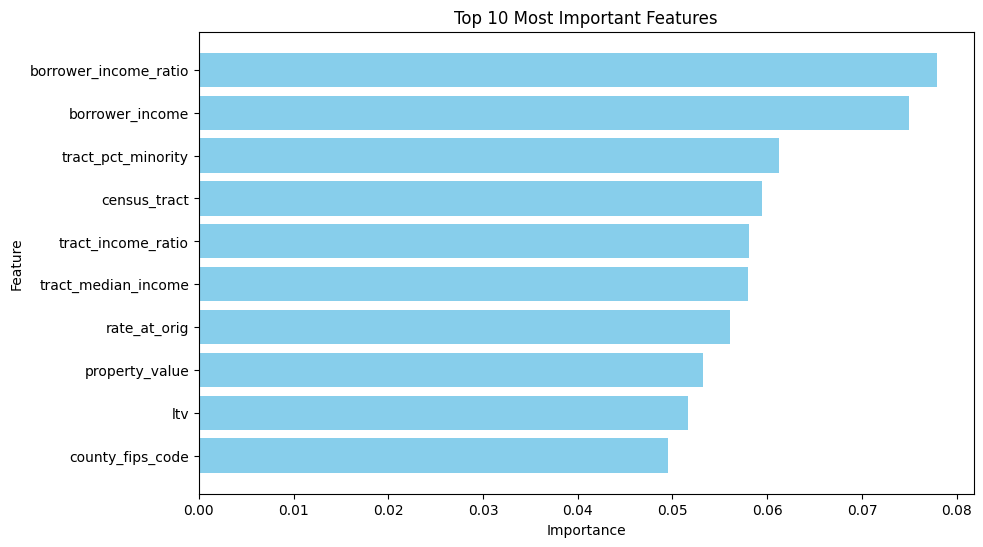

In [14]:
# Select the top 10 most important features
top_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()

In [15]:
##LTV regression example

In [24]:
# census_tract, county_fips_code, and msa_code all have too many values to reasonably one-hot encode
# dti_num is redundant
# property_val is the most important variable when used, presumably because it is directly used to calculate ltv
pred_df_ltv = df_sf_fred_2022_clean_sampled.drop(columns=['property_value', 'dti_num', 'county_fips_code', 'census_tract', 'msa_code'])
pred_df_ltv.dtypes

persistent_poverty_county     category
mississippi_delta_county      category
property_type                 category
date_of_note                  category
borrower_income                  int64
num_borrowers                 category
mid_appalachia_county         category
high_opportunity_area         category
occupancy_code                category
num_units                     category
purpose                       category
term_at_orig                  category
upb                              int64
area_concentrated_poverty     category
state_fips_code               category
federal_guarantee             category
rural_tract                   category
tract_pct_minority             float64
tract_median_income            float64
local_median_income            float64
tract_income_ratio             float64
local_median_family_income     float64
borrower_income_ratio          float64
ltv                            float64
rate_at_orig                   float64
note_amount              

In [25]:
#convert categorical fields to binary
categorical_cols = ['state_fips_code', 'num_borrowers', 'area_concentrated_poverty', 'property_type', 'rural_tract', 'occupancy_code', 'persistent_poverty_county', 'mississippi_delta_county', 'num_units', 'date_of_note', 'mid_appalachia_county', 'high_opportunity_area', 'purpose', 'term_at_orig', 'federal_guarantee', 'first_time_buyer', 'borrower_age', 'borrower_62+', 'application_channel', 'AUS_name', 'dti_cat']
pred_df_ltv = pd.get_dummies(pred_df_ltv, columns=categorical_cols, drop_first = True)
pred_df_ltv = pred_df_ltv.astype(int)

In [26]:
#split data into x, y
y = pred_df_ltv['ltv']
X = pred_df_ltv.drop(columns=['ltv'])

In [27]:
#train random forest regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MSE: 155.30352688198315
RMSE: 12.462083569049886
R^2: 0.555970970716138


In [28]:
#extract feature importance and create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': random_forest.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

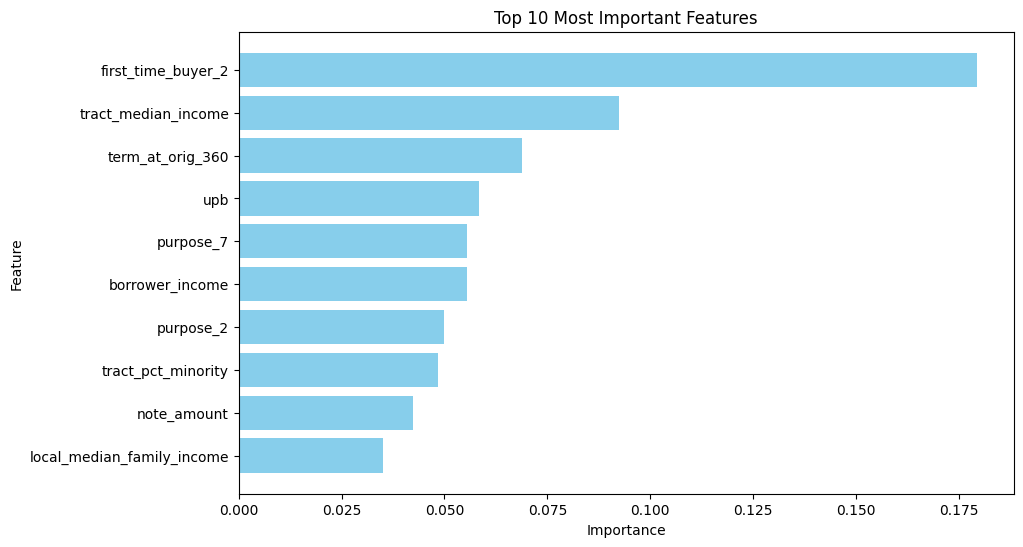

In [29]:
# Select the top 10 most important features
top_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  
plt.show()